# Floating-point arithmetic

Arbitrary real numbers on computers are typically approximated by a set $\mathbb{F}$ of [floating-point numbers](https://en.wikipedia.org/wiki/Floating_point).  Basically, you should think of these as numbers in "scientific notation:"
$$
\pm\underbrace{d_0.d_1 d_2 d_3 ... d_{p-1}}_\textrm{significand} \times \beta^e, \;\; 0 \le d_k < \beta
$$
where the $d_k$ are digits of the **significand** in some base $\beta$ (typically $\beta=2$), the number of digits $p$ is the **precision**, and $e$ is the **exponent**.  That is, the computer actually stores a tuple (*sign*,*significand*,*exponent*), representing *a fixed number of significant digits over a wide range of magnitudes*.

More concisely, in the usual "binary" floating point (β=2), **floating-point numbers (𝔽) are p-digit integers times powers of 2**.

One goal of [numerical analysis](https://en.wikipedia.org/wiki/Numerical_analysis) is to eventually understand the set $\mathbb{F}$, how *rounding* occurs when you operate on floating-point values, how rounding errors *accumulate*, and how you analyze the accuracy of numerical algorithms.  In this notebook, however, we will just perform a few informal experiments in [Julia](http://julialang.org/) to get a feel for things.

## Entering and working with floating-point values

In [1]:
1.5e7 # a floating-point value 1.5 × 10⁷

1.5e7

In [2]:
x = 1/49 # division of two integers produces a floating-point value

0.02040816326530612

Since $1/49 \notin \mathbb{F}$, however, $x$ is actually a *rounded* version of $1/49$, and multiplying it by $49$ will yield something that is close to but *not quite equal to 1*.

In [3]:
x * 49

0.9999999999999999

In [4]:
1 - x * 49

1.1102230246251565e-16

This is about $10^{-16}$ because the default floating-point precision in Julia is **double precision**, with $p=53$ bits of significand ($\beta=2$).   Double precision, called the `Float64` type in Julia (64 bits overall), is used because it is **fast**: double-precision floating-point arithmetic is implemented by dedicated circuits in your CPU.

The precision can also be described by $\epsilon_\mathrm{machine} = 2^{1-p}$, which bounds the *relative error* between any element of $\mathbb{R}$ and the closest element of $\mathbb{F}$.  It is returned by `eps()` in Julia:

In [5]:
2.0^-52, eps(), eps(1.0), eps(Float64) # these are all the same thing

(2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16)

* An error by 1 in the **last significant digit** is called a **1 [ulp](https://en.wikipedia.org/wiki/Unit_in_the_last_place)** (**u**nit in the **l**ast **p**lace) error, equivalent to a relative error of $\epsilon_\mathrm{machine}$.

In fact, there is typically a small rounding error as soon as you enter a floating-point value, because most decimal fractions are not in $\mathbb{F}$.   This can be seen by either:
* converting to a higher precision with `big(x)` (converts to `BigFloat` [arbitrary-precision](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic) value, by default with $p=256 \mathrm{bits}$ or about $77 \approx 256 \times \log_{10}(2)$ decimal digits)
* comparing to an exact rational — in Julia, `p // q` produces a `Rational` type, which is stored as a pair of integers

In [6]:
setprecision(BigFloat, 256)

256

In [7]:
big(1)/big(49)

0.02040816326530612244897959183673469387755102040816326530612244897959183673469376

In [8]:
49 * (big(1)/big(49)) - 1

-8.636168555094444625386351862800399571116000364436281385023703470168591803162427e-78

In [9]:
3//2

3//2

In [10]:
typeof(3//2)

Rational{Int64}

In [11]:
dump(3//2) # dump lets us see how the underlying data of Rational is stored, as 2 integers

Rational{Int64}
  num: Int64 3
  den: Int64 2


In [12]:
# 1.5 is exactly represented in binary floating point:
big(1.5) == 3//2, 1.5 == 3//2

(true, true)

In [13]:
1/49 == 1//49

false

In [14]:
# 0.1 is *not* exactly represented
big(0.1), 0.1 == 1//10

(0.1000000000000000055511151231257827021181583404541015625, false)

Note that when you enter a floating-point literal like `0.1` in Julia, it is immediately converted to the nearest `Float64` value.   So `big(0.1)` *first* rounds `0.1` to `Float64` and *then* converts to `BigFloat`.

If, instead, you want to round `0.1` to the nearest `BigFloat` directly, you have to use a different "string macro" input format:

In [15]:
big"0.1"

0.1000000000000000000000000000000000000000000000000000000000000000000000000000002

In [16]:
# 1e10 in 𝔽 for Float64 (about 15 decimal digits)
big(1e10)

1.0e+10

In [17]:
# 1e100 is also *not* exactly represented in Float64 precision,
# since it not a "small" (≈15 digit) integer times a power of two,
# but *is* exactly represented in 256-bit BigFloat:

big(1e100) # rounds 1e100 to Float64 then extends to BigFloat

1.000000000000000015902891109759918046836080856394528138978132755774783877217038e+100

In [18]:
big"1e100" # exact in 256-bit BigFLoat

1.0e+100

## Fundamental Axioms of Floating-Point Arithmetic

A basic tool for analysis of floating-point arithmetic, following the notation in [Trefethen & Bau's *Numerical Linear Algebra*](https://people.maths.ox.ac.uk/trefethen/text.html), is the following two axioms:

* $\operatorname{fl}(x) = $ **closest** floating point number $\in \mathbb{F}$ to $x \in \mathbb{R}$.
* $\oplus,\ominus,\otimes,\oslash$ denote the *floating-point* versions of $+,-,\times,/$.

In analyzing roundoff errors theoretically, we mostly **ignore overflow/underflow** (discussed below), i.e. we ignore the limited range of the exponent $e$.  In this case, we have the following property:

* $\operatorname{fl}(x) = x (1 + \epsilon)$ for some $|\epsilon| \le \epsilon_\mathrm{machine}$ 
* $\boxed{x \odot y = (x \cdot y) (1 + \epsilon)}$ for some $|\epsilon| \le \epsilon_\mathrm{machine}$ where "$\cdot$" is one of $\{+,-,\times,/\}$ and $\odot$ is the floating-point analogue.

That is these operations have **relative** error bounded above by $\epsilon_\mathrm{machine}$.   In fact, it turns out that floating-point operations have an even stronger guarantee in practice, called **correct rounding** or **exact rounding**:

* $x \odot y = \operatorname{fl}(x \cdot y)$

That is, $\{+,-,\times,/\}$ behave *as if* you computed the result *exactly* and then rounded to the **closest** floating-point value.   So, for example:

In [19]:
1.0 + 1.0 == 2.0

true

is guaranteed to be true — **integer arithmetic is exact** in floating-point until you exceed the largest exactly representable integer in your precision.

(It is a common misunderstanding that floating-point addition/subtraction/multiplication of small integers might give "random" rounding errors, e.g. many people seem to think that `1.0 + 1.0` might give something other than `2.0`.   Similarly, floating-point arithmetic guarantees that `x * 0 == 0` for any finite `x`.)

It is important to realize that these accuracy guarantees are **only for individual operations**.   If you perform many operations, the **errors can accumulate**, as we will discuss in more detail below.

### Decimal input and output

A confusing aspect of floating-point arithmetic is that, since the default types are *binary*, it means that some rounding occurs on human-readable *decimal* values for **both input and output**.  

* There is something called [decimal floating point](https://en.wikipedia.org/wiki/Decimal_floating_point) (base $\beta=10$) that avoids this issue, but it isn't supported by typical computer hardware so it is slow and only used for relatively specialized applications; you can do it in Julia with the [DecFP package](https://github.com/JuliaMath/DecFP.jl).

We already said that a value like `1e-100` in Julia really means $\operatorname{fl}({10^{-100}})$ (in `Float64` precision): the result is "immediately" rounded to the nearest `Float64` value by the parser.   But what does it mean when this value is *printed* as output?

In [20]:
1e-100

1.0e-100

At first glance, the printed output is $10^{-100}$.  Technically, however, this answer **really** means that the output is $\operatorname{fl}({10^{-100}})$.

A lot of research has gone into the deceptively simple question of how to print (binary) floating-point values as human-readable decimal values.   Printing the *exact* decimal value is possible for any integer times a power of two, but might require a huge number of digits:

In [21]:
setprecision(4096) do # even 256 digits isn't enough: temporarily increase BigFloat precision
    big(1.0e-100)
end

1.00000000000000001999189980260288361964776078853415942018260300593659569925554346761767628861329298958274607481091185079852827053974965402226843604196126360835628314127871794272492894246908066589163059300043457860230145025079449986855914338755579873208034769049845635890960693359375e-100

We don't really want to see all of these digits every time we display floating-point values on a computer, however, particularly since most of them are "garbage" (roundoff errors).

As a result, every popular computer language performs some kind of rounding when it *outputs* floating-point values.  The [algorithm used by Julia](https://dl.acm.org/doi/10.1145/3192366.3192369) actually prints the **shortest decimal value** that **rounds to the same floating-point value**!

### Non-associativity:

In particular, note that floating-point arithmetic is **not associative**: $(x \oplus y) \oplus z \ne x \oplus (y \oplus z)$ in general (and similarly for $\ominus, \otimes$).  For example

In [22]:
(1.0 + -1.0) + 1e-100

1.0e-100

In [23]:
1.0 + (-1.0 + 1e-100)

0.0

This is an example of **catastrophic cancellation**: we lost *all* the significant digits.  We'll talk more about this below.

Even 256 bits of precision (77 decimal digits) is not enough to avoid catastrophic cancellation here:

In [24]:
big"1.0" + (big"-1.0" + big"1e-100")

0.0

This happens because $-1.0 \oplus \operatorname{fl}(10^{-100}) = -1.0$ in double precision — we only have about 15 decimal places of precision, so the exact result is rounded to $-1.0$.

## Overflow, Underflow, Inf, and NaN

Because a floating-point value uses a finite number of bits to store the exponent `e`, there is a maximum and minimum magnitude for floating-point values.   If you go over the maximum, you **overflow** to a special `Inf` value (or `-Inf` for large negative values), representing $\infty$.   If you go under the minimum, you **underflow** to $\pm 0.0$, where $-0$ is used to represent e.g. a value that underflowed from the negative side.

In [25]:
1e300 # okay: 10³⁰⁰ is in the representable range

1.0e300

In [26]:
(1e300)^2 # overflows

Inf

In [27]:
-Inf

-Inf

In [28]:
1 / Inf

0.0

We can get the maximum representable magnitude via `floatmax`

In [29]:
floatmax(Float64), floatmax(Float32)

(1.7976931348623157e308, 3.4028235f38)

In [30]:
1e-300 # okay

1.0e-300

In [31]:
(1e-300)^2 # underflows to +0

0.0

You can use `floatmin` in Julia to find the minimum-magnitude floating-point value:

In [32]:
floatmin(Float64), floatmin(Float32)

(2.2250738585072014e-308, 1.1754944f-38)

In [33]:
-1e-300 * 1e-300 # underflows to -0

-0.0

While -0 is printed differently from +0, they still compare equal.  However, you will notice the difference if you do something that depends on the sign:

In [34]:
+0.0 == -0.0

true

Dividing by zero gives `Inf`, as you expect, or `-Inf` if you divide by "negative zero":

In [35]:
1 / +0.0, 1 / -0.0

(Inf, -Inf)

In [36]:
signbit(+0.0), signbit(-0.0)

(false, true)

Since 1/-Inf is -0.0, this has the nice property that:

In [37]:
1 / (1 / -Inf)

-Inf

A special value `NaN` ("not a number") is used to represent the result of floating-point operations that can't be defined in a sensible way (e.g. [indeterminate forms](https://en.wikipedia.org/wiki/Indeterminate_form)):

In [38]:
0 * Inf, Inf / Inf, 0 / 0, 0 * NaN

(NaN, NaN, NaN, NaN)

So, **non-finite** values are the exception to the rule that $0 \otimes x == 0$ in floating-point arithmetic.

In fact, `NaN` has the odd property that it is the *only* number that is not equal to itself:

In [39]:
NaN == NaN

false

One way of viewing IEEE's semantics is that a `NaN` can be viewed as a stand-in for *any* value, or *none*, so `NaN` values arising from different sources are not equivalent.  (In some statistical software, `NaN` is also used to represent missing data, but Julia has a special [`missing` value](https://docs.julialang.org/en/v1/manual/missing/) for this.)

(There is another function [`isequal` in Julia](https://docs.julialang.org/en/v1/base/base/#Base.isequal) that can be treats NaN values as equal in cases where that is needed.)

You can check for non-finite values like this with `isnan`, `isinf`, and `isfinite`:

In [40]:
isinf(2.5), isinf(Inf), isinf(-Inf), isinf(NaN)

(false, true, true, false)

In [41]:
isnan(2.5), isnan(Inf), isnan(-Inf), isnan(NaN)

(false, false, false, true)

In [42]:
isfinite(2.5), isfinite(Inf), isfinite(-Inf), isfinite(NaN)

(true, false, false, false)

In some other languages, `NaN` is also used to signal that a function cannot be evaluated.  For example, in C, `sqrt(-1.0)` returns `NaN`.  However, Julia typically [throws](http://docs.julialang.org/en/latest/manual/control-flow/#man-exception-handling) an [exception](https://en.wikipedia.org/wiki/Exception_handling) in these cases:

In [43]:
sqrt(-1.0)

LoadError: DomainError with -1.0:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).

If you want a complex *output* from the `sqrt` function, you need to give it a complex *input*:

In [44]:
sqrt(-1.0 + 0im)

0.0 + 1.0im

The reason for this is a technical criterion called [type stability](http://docs.julialang.org/en/latest/manual/performance-tips/#write-type-stable-functions) that is essential for Julia code to be compiled to fast machine instructions.  (The lack of type stability in many standard-library functions is a key contributor to the difficulty of retrofitting fast compilers to languages like Python and Matlab.)

## Cancellation error

One common source of huge floating-point errors is a [catastrophic cancellation](https://en.wikipedia.org/wiki/Loss_of_significance): if you **subtract two nearly equal numbers** then most of the significant digits cancel, and the result can have a relative error $\gg \epsilon$.

Catastrophic cancellation is not inevitable, however!  Often it can be avoided simply by **re-arranging your calculation**.

### The `expm1` function

Suppose you are calculating the function $e^x - 1$ using floating-point arithmetic.   When $|x| \ll 1$, we have $e^x \approx 1$, and so a naive calculation $e^x \ominus 1$ will experience catastrophic cancellation:

In [45]:
x = 2.0^-60
@show x
@show exp(x)
@show exp(x) - 1 # naive algorithm: catastrophic cancellation

x = 8.673617379884035e-19
exp(x) = 1.0
exp(x) - 1 = 0.0


0.0

This result `0.0` has **no correct digits**.  The correct answer is:

In [46]:
# naive algorithm computed in BigFloat precision and rounded back to Float64:
Float64(exp(big(x)) - 1)

8.673617379884035e-19

You can also see this using the Taylor series for $e^x$:

$$
e^x = 1 + x + \frac{x^2}{2} + \cdots + \frac{x^n}{n!} + \cdots
$$

From this, we immediately see that floating-point arithmetic *must* give `exp(x) == 1.0` for $|x| < \epsilon_\mathrm{machine}$, because in that case $(1 \oplus x) \oplus \cdots = 1$.

In contrast, $e^x - 1$ has a Taylor series:
$$
e^x - 1 = \left(1 + x + \frac{x^2}{2} + \cdots + \frac{x^n}{n!} + \cdots\right) - 1 = \boxed{x + \frac{x^2}{2} + \cdots + \frac{x^n}{n!} + \cdots}
$$
which we could use to calculate this function accurately for small $x$:

In [47]:
x + x^2/2 + x^3/6 # 3 terms is more than enough for x ≈ 8.7e-19

8.673617379884035e-19

In [48]:
x # in fact, just one term is enough

8.673617379884035e-19

The key is to **rearrange the calculation** to **perform the cancellation analytically**, and only use floating-point arithmetic *after* this is accomplished.

In fact, Julia's standard library (and scientific-computing libraries in other languages) provides a function called `expm1(x)` that computes $e^x - 1$ accurately for all `x`:

In [49]:
expm1(x)

8.673617379884035e-19

Such [special functions](https://en.wikipedia.org/wiki/Special_functions) can be implemented in many ways.  One possible implementation of `expm1` might be:

* Just do `exp(x) - 1` if $|x|$ is sufficiently large.
* Use the Taylor series if $|x|$ is small.
* In between (e.g. $|x| \sim 1$), to avoid requiring many terms of the Taylor series, one could use some kind of fit, e.g. a [minimax polynomial](https://en.wikipedia.org/wiki/Minimax_approximation_algorithm) or [rational function](https://en.wikipedia.org/wiki/Rational_function).

(In general, special-function implementations typically use some combination of Taylor series near zeros, minimax fits, continued-fraction expansions or asymptotic series, and function-specific identities.  This is a branch of numerical analysis that we won't delve into in 18.335.)

Sometimes, a simple (but often non-obvious) algebraic rearrangement leads to a formula that is accurate for all $x$.  For example, in this case one can use the exact identities:
$$
e^x - 1 = \left(e^x+1\right)\tanh(x/2) = \frac{\left(e^x - 1\right) x}{\log\left(e^x\right)}
$$
and it turns out that the catastrophic cancellation is avoided with either of the two expressions at right, at the cost of calling `tanh` or `log` in addition to `exp`.  See e.g. Higham, [*Accuracy and Stability of Numerical Algorithms*](https://epubs.siam.org/doi/book/10.1137/1.9780898718027?mobileUi=0) (2002), p. 30 for more explanation and references.

### Quadratic roots

If you are finding solutions of the quadratic equation
$$
ax^2 + bx + c = 0
$$
you will surely reach for the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula):
$$
x_\pm = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$
However, suppose $b > 0$ and $|ac| \ll b^2$.   In this case, $\sqrt{b^2 - 4ac} \approx b$.  The $x_-$ root will be fine, but the $x_+$ root will suffer from a catastrophic cancellation because $-b + \sqrt{\cdots}$ is the difference of two nearly equal quantities.

To compute $x_+$, we could again use a Taylor series, but it turns out that we can instead use a simple re-arrangement:
$$
x_\pm = \frac{2c}{-b \mp \sqrt{b^2 - 4ac}}
$$
which comes from dividing our quadratic equation by $x^2$ and applying the standard quadratic formula to $cy^2 + by + a = 0$ where $y = 1/x$.   This "inverted" form of the quadratic formula is accurate for $x_+$ (again assuming $b > 0$) but may have catastrophic cancellation for $x_-$.

So, we just use the first quadratic formula for the $x_-$ root and the second "inverted" quadratic formula for the $x_+$ root:
$$
x_+, \, x_- = \frac{2c}{-b - \sqrt{b^2 - 4ac}},\;\frac{-b - \sqrt{b^2 - 4ac}}{2a} \, .
$$
No increase in computational cost, just a little thought and rearrangement.

## Accumulation of roundoff errors

A common mistake is to confuse **precision** with **accuracy**.   A value can be *more accurate* or *less accurate* than the precision (number of digits) with which it is represented.

For example, the value `3.0` in floating point (represented exactly in $\mathbb{F}$) is an exact value for the number of sides of a triangle, but a rather inaccurate approximation for π.

Most commonly, floating-point values are *less accurate* than the precision allows, because **roundoff errors accumulate** over the course of a long computation.   To see this, let us consider the function `y = cumsum(x)` in Julia, which computes
$$
y_k = \sum_{i=1}^k x_i
$$
We will try this for random $x_i \in [0,1)$, and compare to the "exact" value of the sum.  Although `cumsum` is built-in to Julia, we will write our own version so that we can see exactly what it is doing:

In [50]:
function my_cumsum(x)
    y = similar(x) # allocate an array of the same type and size as x
    y[1] = x[1]
    for i = 2:length(x)
        y[i] = y[i-1] + x[i]
    end
    return y
end

my_cumsum (generic function with 1 method)

Now, how to we get the "exact" sum for comparing the error?   One possible trick is that we can do the sum in **two precisions**: *double precision* and *single precision* (Julia `Float32` = 32 bits), where single precision is about 7-8 decimal digits ($p=24$ bits).  Since double precision has about twice as many digits as single precision, we can treat the double precision result as "exact" compared to the single-precision result in order to compute the accuracy in the latter.

* Alternatively, there is a package called [Xsum.jl](https://github.com/stevengj/Xsum.jl) for Julia that computes exactly rounded sums in double precision using an [algorithm by Radford Neal](https://arxiv.org/abs/1505.05571) that uses a little bit of extra precision as needed.

In [51]:
eps(Float32), eps(Float64)

(1.1920929f-7, 2.220446049250313e-16)

  0.020385 seconds (16.67 k allocations: 39.050 MiB, 30.65% compilation time)


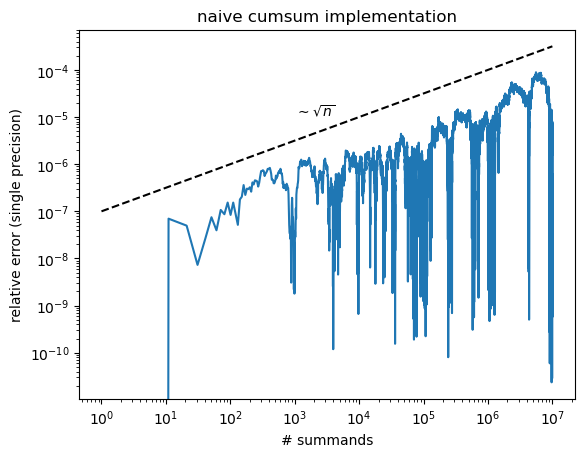

PyObject Text(0.5, 1.0, 'naive cumsum implementation')

In [52]:
x = rand(Float32, 10^7) # 10^7 single-precision values uniform in [0,1)
@time y = my_cumsum(x)
yexact = my_cumsum(Float64.(x)) # same thing in double precision
err = abs.(y .- yexact) ./ abs.(yexact) # relative error in y

using PyPlot
n = 1:10:length(err) # downsample by 10 for plotting speed
loglog(n, err[n])
ylabel("relative error (single precision)")
xlabel("# summands")
# plot a √n line for comparison
loglog([1,length(err)], sqrt.([1,length(err)]) * 1e-7, "k--")
text(1e3,1e-5, L"\sim \sqrt{n}")
title("naive cumsum implementation")

Note that the error starts around $10^{-7}$ (about `eps(Float32)`), but gets worse than the precision as the number of summands grows.

As you can see, the relative error has an upper bound that scales roughly proportional $\sqrt{n}$ where $n$ is the number of summands.   Intuitively, there is a little roundoff error from each addition, but the roundoff error is somewhat random in $[-\epsilon,+\epsilon]$ and hence the roundoff errors grow as a [random-walk](https://en.wikipedia.org/wiki/Random_walk) process $\sim \sqrt{n}$.

However, **one can do better than this**.  If you use the built-in `cumsum` function, you will see *very different* error growth: the mean errors actually grow as roughly $\sqrt{\log n}$.  Not only that, but the output of the `@time` macro indicates that the built-in `cumsum` (which is also written in Julia) is actually a bit *faster* than our `my_cumsum`.

  0.024061 seconds (79.19 k allocations: 42.253 MiB, 47.20% compilation time)


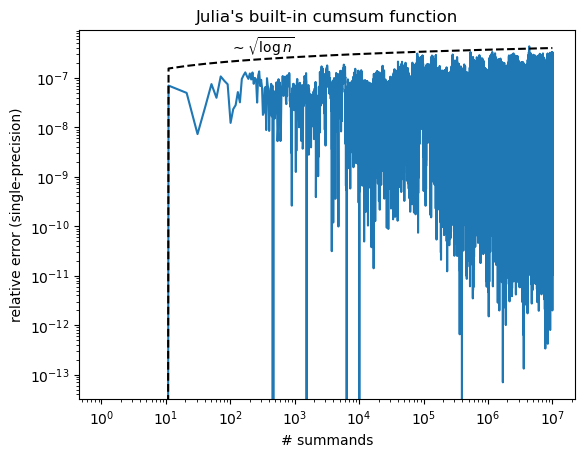

PyObject Text(100.0, 3.3e-07, '$\\sim \\sqrt{\\log n}$')

In [53]:
@time y2 = cumsum(x)
err2 = abs.(y2 .- yexact) ./ abs.(yexact)
loglog(n, err2[n])
ylabel("relative error (single-precision)")
xlabel("# summands")
title("Julia's built-in cumsum function")
loglog(n, sqrt.(log.(n)) * 1e-7, "k--")
text(1e2,3.3e-7, L"\sim \sqrt{\log n}")

Julia's `cumsum` is using an algorithm called [pairwise summation](https://en.wikipedia.org/wiki/Pairwise_summation), which simply does the same summation in a different order to get much greater accuracy for essentially the same performance.  To understand how this works requires a deeper analysis.

## Rounding mode

By default, each elementary floating-point operation (`+`, `-`, `*`, `/`) behaves as if it computed its result in infinite precision and then rounded the result to the *nearest* floating-point value (rounding to the nearest *even* value in the case of ties).  This is called **correct rounding** or **exact rounding**.

The `rounding` function in Julia returns the current rounding behavior for a given type, and defaults to rounding to the nearest value:

In [54]:
rounding(Float32)

RoundingMode{:Nearest}()

However, it is possible to *change* the rounding mode to always round *up* (or *down*) with the `setrounding` function from the [SetRounding.jl package](https://github.com/JuliaIntervals/SetRounding.jl).  (In C/C++ you would use the [`fesetround`](https://en.cppreference.com/w/c/numeric/fenv/feround) function.)

First, let's install this package if needed.  We can do `import Pkg` followed by `Pkg.add("SetRounding")`, but it is nicer to simply start an input cell with `]` at which point you are in "package mode" and have a set of [nice package-management commands](https://docs.julialang.org/en/v1/stdlib/Pkg/) available:

In [55]:
] add SetRounding

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [3cc68bcd] + SetRounding v0.2.1
  [221a10cb] ~ StripRTF v1.0.0-DEV `~/.julia/dev/StripRTF` ⇒ v1.0.0 `~/.julia/dev/StripRTF`
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [3cc68bcd] + SetRounding v0.2.1
  [221a10cb] ~ StripRTF v1.0.0-DEV `~/.julia/dev/StripRTF` ⇒ v1.0.0 `~/.julia/dev/StripRTF`
Precompiling project...
  ✓ SetRounding
  1 dependency successfully precompiled in 2 seconds. 409 already precompiled.


In [56]:
using SetRounding

Changing the rounding mode is supported in the CPU hardware, so it doesn't change the speed of floating-point arithmetic.   It can be extremely useful to gain an understanding of the roundoff errors in a problem, and can even be used to implement [interval arithmetic](https://en.wikipedia.org/wiki/Interval_arithmetic), in which you compute a range `[a,b]` that bounds your error rather than a single rounded value — see [IntervalArithmetic.jl](https://github.com/JuliaIntervals/IntervalArithmetic.jl) in Julia. 

In the case of our summation problem, we can change to rounding up, which will result in a very different error growth: O(n) rather than O(√n).  The errors now all accumulate in the same direction, so they no longer form a random walk.

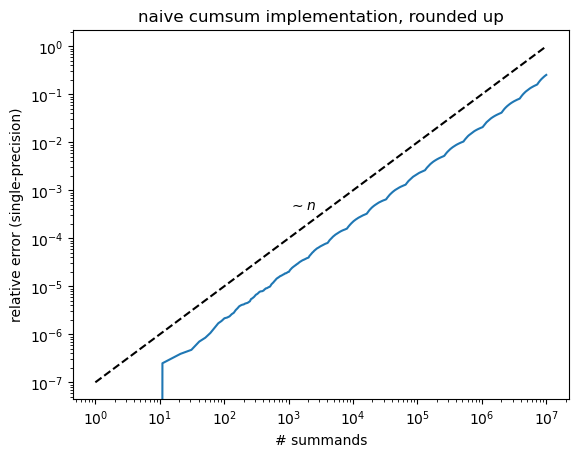

PyObject Text(0.5, 1.0, 'naive cumsum implementation, rounded up')

In [57]:
errup = setrounding(Float32, RoundUp) do
    # error in single-precision (Float32) sum, rounding temporarily set to RoundUp
    abs.(my_cumsum(x) .- yexact) ./ abs.(yexact) # relative error in y
end

loglog(n, errup[n])
ylabel("relative error (single-precision)")
xlabel("# summands")
# plot an O(n) line for comparison
loglog([1,length(errup)], [1,length(errup)] * 1e-7, "k--")
text(1e3,4e-4, L"\sim n")
title("naive cumsum implementation, rounded up")